In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
from astropy.table import Table
dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction"
history_fname = "sfh_catalog_1.002310_smcut_9.50_formatted_histories.hdf5"
histories = Table.read(os.path.join(dirname, history_fname), path='data')

universe_age_array_fname = os.path.join(dirname, "times.npy")
universe_age_array = np.load(universe_age_array_fname)

In [3]:
from quenching_time import quenching_indices
from mass_loss import ssfr_t_now

In [4]:
ssfr_matrix = np.zeros_like(histories['sfh'])
for i, t in enumerate(universe_age_array):
    ssfr_matrix[:, i] = ssfr_t_now(histories['sfh'], t)

In [5]:
idx_quenching_times = quenching_indices(ssfr_matrix <= 1e-11)
quenching_times = universe_age_array[idx_quenching_times]
histories['quenching_time'] = quenching_times

# crossmatch with bolplanck halo catalog

In [6]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)
halo_id = halocat.halo_table['halo_id']

In [54]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(histories['id'], halocat.halo_table['halo_id'])

histories['upid'] = 0L
histories['upid'][idxA] = halocat.halo_table['halo_upid'][idxB]

histories['halo_scale_factor_mpeak'] = -1.
histories['halo_scale_factor_mpeak'][idxA] = halocat.halo_table['halo_scale_factor_mpeak'][idxB]

histories['halo_scale_factor_firstacc'] = 0.
histories['halo_scale_factor_firstacc'][idxA] = halocat.halo_table['halo_scale_factor_firstacc'][idxB]

histories = histories[histories['halo_scale_factor_mpeak'] != -1]

In [55]:
quenched_cenmask = (histories['upid'] == -1) & (histories['sfr']/histories['sm'] < 1e-11)
quenched_cens = histories[quenched_cenmask]

quenched_satmask = (histories['upid'] != -1) & (histories['sfr']/histories['sm'] < 1e-11)
quenched_sats = histories[quenched_satmask]

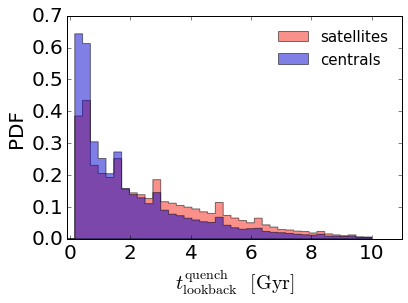

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$t_{\rm lookback}^{\rm quench}$  $[{\rm Gyr}]$', fontsize=20)
ylabel = ax.set_ylabel(r'PDF', fontsize=20)
# title = ax.set_title('some title', fontsize=20, y=1.02) # y param fixes an overhanging title

plt.hist(universe_age_array[-1] - quenched_sats['quenching_time'], 
              normed=True, bins=np.linspace(-0.1, 10, 40), color='#f62217', 
              histtype='stepfilled', alpha=0.5, label='satellites')

plt.hist(universe_age_array[-1] - quenched_cens['quenching_time'], 
              normed=True, bins=np.linspace(-0.1, 10, 40), color='mediumblue', 
              histtype='stepfilled', alpha=0.5, label='centrals')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(xmin = -0.1, xmax=11)
plt.legend(loc='upper right', fontsize=15, frameon=False)

# plt.savefig('FIGS/cens_sats_quenching_time.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

### now calculate the age-of-accretion from the scale-factor-of-accretion

In [67]:
from astropy.cosmology import Planck13

qsats_aacc = quenched_sats['halo_scale_factor_firstacc']
qsats_zacc = 1./qsats_aacc - 1.

qsats_tacc = Planck13.age(qsats_zacc)

qcens_aacc = quenched_cens['halo_scale_factor_firstacc']
qcens_zacc = 1./qcens_aacc - 1.

qcens_tacc = Planck13.age(qcens_zacc)

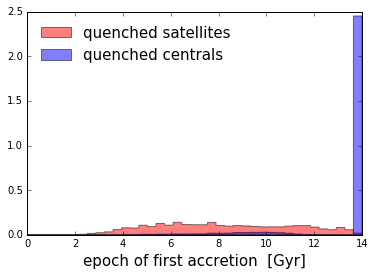

In [93]:
__ = plt.hist(qsats_tacc, 
              normed=True, bins=np.linspace(0, 14, 40), color='r', 
              histtype='stepfilled', alpha=0.5, label='quenched satellites')

__ = plt.hist(qcens_tacc, 
              normed=True, bins=np.linspace(0, 14, 40), color='blue', 
              histtype='stepfilled', alpha=0.5, label='quenched centrals')

plt.xlabel('epoch of first accretion  [Gyr]', size=15)
plt.legend(frameon=False, loc='upper left', fontsize=15)

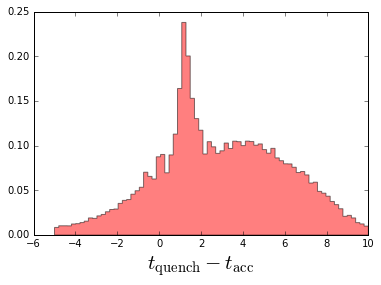

In [105]:
qsats_accretion_quenching_timescale = quenched_sats['quenching_time'] - qsats_tacc.value

__ = plt.hist(qsats_accretion_quenching_timescale, 
              normed=True, bins=np.linspace(-5, 10, 75), color='red', 
              histtype='stepfilled', alpha=0.5, label='quenched satellites')

plt.xlabel(r'$t_{\rm quench} - t_{\rm acc}$', size=21)

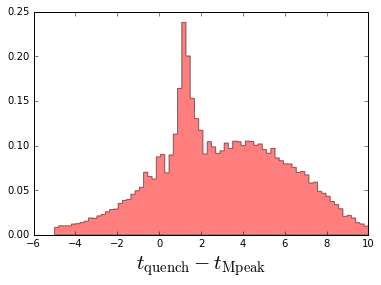

In [106]:
qsats_mpeak_quenching_timescale = quenched_sats['quenching_time'] - qsats_tacc.value

__ = plt.hist(qsats_mpeak_quenching_timescale, 
              normed=True, bins=np.linspace(-5, 10, 75), color='red', 
              histtype='stepfilled', alpha=0.5, label='quenched satellites')
plt.xlabel(r'$t_{\rm quench} - t_{\rm Mpeak}$', size=21)

# now for something different

In [131]:
histories.keys()

['id',
 'sm',
 'sfr',
 'sfh',
 'iclh',
 'quenching_time',
 'upid',
 'halo_scale_factor_mpeak',
 'halo_scale_factor_firstacc']

itest = 161195
central galaxy with stellar mass of 10.64 and sSFR of -10.17
Why is this galaxy not shown as quenched?


/Users/aphearin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10


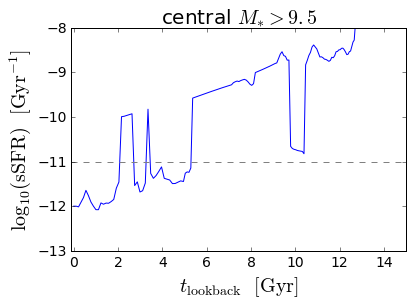

In [207]:
itest=np.random.randint(0, len(histories)-1)
itest = 161195


print("itest = {0}".format(itest))

h = histories[itest]
if h['upid'] == -1:
    gal_type = 'central'
else:
    gal_type = 'satellite'
    

ssfr_array = ssfr_matrix[itest, :]

print("{0} galaxy with stellar mass of {1:.2f} and sSFR of {2:.2f}".format(
    gal_type, np.log10(h['sm']), np.log10(h['sfr']/h['sm']) ))

if np.log10(h['sfr']/h['sm']) < -11:
    line_color = 'red'
else:
    line_color = 'blue'

toy_history = np.log10(ssfr_array)
plt.plot(universe_age_array[-1] - universe_age_array, toy_history, color=line_color)
plt.plot(np.linspace(-0.1, 15, 100), np.zeros(100)-11, '--', color='gray')

if gal_type == 'central':
    plt.title(r'central $M_{\ast} > 9.5$', size=20)
else:
    plt.title(r'satellite $M_{\ast} > 9.5$', size=20)
    
plt.xlabel(r'$t_{\rm lookback}$  $[{\rm Gyr}]$', size=20)
plt.xticks(size=14); plt.yticks(size=14)
plt.ylabel(r'${\rm log_{10}(sSFR})$  $[{\rm Gyr^{-1}}]$', size=20)

plt.xlim(xmin=-0.1, xmax=15)
plt.ylim(ymin=-13, ymax=-8)

print("Why is this galaxy not shown as quenched?")

# Something is wrong with these sSFR histories

See itest = 161195, for example